## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow-gpu==2.0.0-beta1


In [0]:
#import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LeakyReLU


In [0]:
tf.__version__

'1.14.0'

## Helper Functions

### Helper-function for joining a directory and list of filenames.

In [0]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for plotting images

Function used to plot at most 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Helper-function for printing confusion matrix

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):

    cm = confusion_matrix(y_true=cls_test,
                          y_pred=cls_pred)

    print("Confusion matrix:")
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [0]:
def plot_example_errors(cls_pred):

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

Function for calculating the predicted classes of the entire test-set and calling the above function to plot a few examples of mis-classified images.

In [0]:
def example_errors():
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1) #np.array([1 if pred >= 0.5 else 0 for pred in y_pred])

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values.

In [0]:
def plot_training_history(history):
  
    acc = history.history['acc']
    loss = history.history['loss']

    val_acc = history.history['acc']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

## PriceHubble Dataset


Connect Colab with Google drive:

In [0]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dir = '../gdrive/My Drive/classified/triple/kit/train'
test_dir = '../gdrive/My Drive/classified/triple/kit/test'

## Pre-Trained Model: VGG16


In [0]:
model = VGG16(include_top=True, weights='imagenet')


W0723 19:23:34.224075 140595696433024 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


553467904/553467096 [==============================] - 13s 0us/step


## Input Pipeline

The Keras API has its own way of creating the input pipeline for training a model using files.

The shape of the tensors expected as input by the pre-trained VGG16 model is 224 x 224 x 3.

In [0]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Define a data-generator for the training set doing some transformations.

In [0]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      #brightness_range=[0.2, 1.0],
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)

In [0]:
batch_size_train = 64
batch_size_test = 16

In [0]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size_train,
                                                    shuffle=True,
                                                    class_mode='categorical')

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size_test,
                                                  shuffle=False,
                                                  class_mode='categorical')
                                        

Found 1344 images belonging to 3 classes.
Found 336 images belonging to 3 classes.


Get the file-paths for all the images in the training- and test-sets.

In [0]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Get the class-numbers for all the images in the training- and test-sets.

In [0]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Get the class-names for the dataset.

In [0]:
class_names = list(generator_train.class_indices.keys())
class_names

['normal-kit', 'simple-kit', 'top-kit']

Get the number of classes for the dataset.

In [0]:
num_classes = generator_train.num_classes
num_classes

3

### Plot a few images to see if data is correct

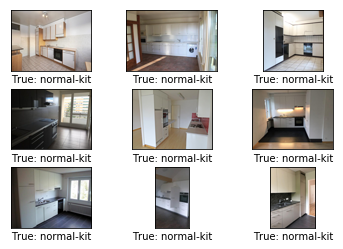

In [0]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Class Weights

In [0]:
from sklearn.utils.class_weight import compute_class_weight

In [0]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [0]:
class_weight

array([1., 1.])

In [0]:
class_names

['simple-kit', 'top-kit']

## Transfer Learning

In [0]:
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
transfer_layer = model.get_layer('block5_pool')

In [0]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [0]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model.
new_model.add(Flatten())

# Add a dense (fully-connected) layer.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(3, activation='softmax'))

In [0]:
optimizer = Adam(lr=1e-3)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

Helper-function for printing whether a layer in the VGG16 model should be trained.

In [0]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

By default all the layers of the VGG16 model are trainable, so disable training for all its layers.

In [0]:
conv_model.trainable = False

In [0]:
for layer in conv_model.layers:
    layer.trainable = False

In [0]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [0]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Define epochs and steps per epoch for the training-set.

In [0]:
epochs = 10
steps_per_epoch = generator_train.n / batch_size_train
steps_test = generator_test.n / batch_size_test
steps_per_epoch

21.0

In [0]:
reduceLROnPlateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.000001,
    verbose=1,
    mode='min')

earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min')


In [0]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  #class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                  callbacks=[reduceLROnPlateau, earlyStopping])

Epoch 1/10
21/21 [==============================] - 476s 23s/step - loss: 6.4570 - acc: 0.3497 - val_loss: 2.1416 - val_acc: 0.4018
Epoch 2/10
21/21 [==============================] - 18s 846ms/step - loss: 1.9539 - acc: 0.4174 - val_loss: 1.0880 - val_acc: 0.4167
Epoch 3/10
21/21 [==============================] - 27s 1s/step - loss: 1.1010 - acc: 0.4561 - val_loss: 0.9647 - val_acc: 0.5685
Epoch 4/10
21/21 [==============================] - 27s 1s/step - loss: 1.0064 - acc: 0.4926 - val_loss: 0.9206 - val_acc: 0.5357
Epoch 5/10
21/21 [==============================] - 27s 1s/step - loss: 0.9867 - acc: 0.5149 - val_loss: 0.8948 - val_acc: 0.6310
Epoch 6/10
21/21 [==============================] - 27s 1s/step - loss: 0.9634 - acc: 0.5238 - val_loss: 0.8930 - val_acc: 0.5893
Epoch 7/10
21/21 [==============================] - 27s 1s/step - loss: 0.9345 - acc: 0.5402 - val_loss: 0.9315 - val_acc: 0.5000
Epoch 8/10
21/21 [==============================] - 27s 1s/step - loss: 0.9436 - acc:

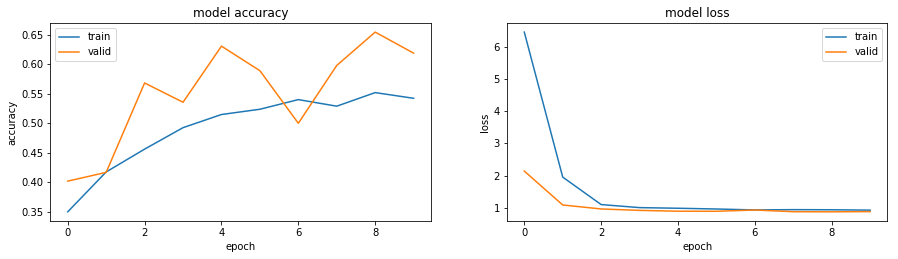

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()


Evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 61.90%


Plot some examples of mis-classified images from the test-set.

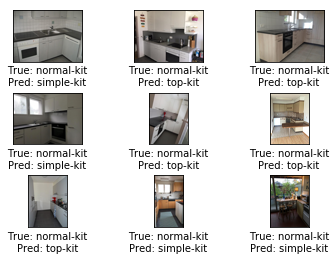

Confusion matrix:
[[  9  41  62]
 [  3  93  16]
 [  1   5 106]]
(0) normal-kit
(1) simple-kit
(2) top-kit


In [0]:
example_errors()


## Fine-Tuning


In [0]:
conv_model.trainable = True

Train the last convolutional layers.

In [0]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name) #or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

Check that this has updated the `trainable` boolean for the relevant layers.

In [0]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


Use a lower learning-rate for the fine-tuning so the weights of the original VGG16 model only get changed slowly.

In [0]:
optimizer_fine = Adam(lr=1e-5)
loss_tune = 'categorical_crossentropy'

Recompile the model so the changes can take effect before we continue training.

In [0]:
new_model.compile(optimizer=optimizer_fine, loss=loss_tune, metrics=metrics)

The training can then be continued so as to fine-tune the VGG16 model along with the new classifier.

In [0]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  #class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)


Epoch 1/10
21/21 [==============================] - 31s 1s/step - loss: 0.9128 - acc: 0.5618 - val_loss: 0.8458 - val_acc: 0.6220
Epoch 2/10
21/21 [==============================] - 28s 1s/step - loss: 0.8843 - acc: 0.5848 - val_loss: 0.8205 - val_acc: 0.6458
Epoch 3/10
21/21 [==============================] - 28s 1s/step - loss: 0.8479 - acc: 0.5982 - val_loss: 0.7959 - val_acc: 0.6458
Epoch 4/10
21/21 [==============================] - 28s 1s/step - loss: 0.8016 - acc: 0.6399 - val_loss: 0.7765 - val_acc: 0.6577
Epoch 5/10
21/21 [==============================] - 27s 1s/step - loss: 0.8196 - acc: 0.6176 - val_loss: 0.7622 - val_acc: 0.6548
Epoch 6/10
21/21 [==============================] - 28s 1s/step - loss: 0.8114 - acc: 0.6324 - val_loss: 0.7642 - val_acc: 0.6577
Epoch 7/10
21/21 [==============================] - 27s 1s/step - loss: 0.8091 - acc: 0.6369 - val_loss: 0.7528 - val_acc: 0.6518
Epoch 8/10
21/21 [==============================] - 27s 1s/step - loss: 0.8029 - acc: 0.61

Plot the loss-values and classification accuracy from the training.

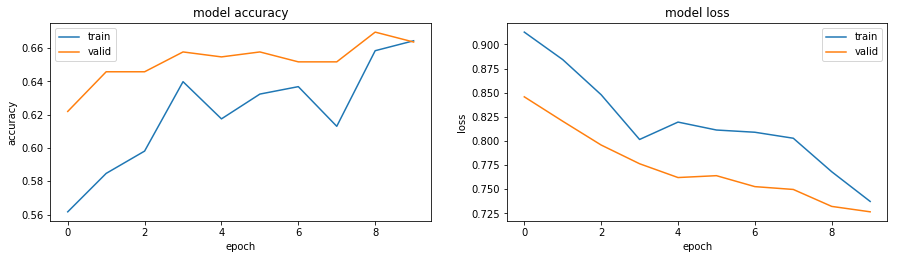

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 66.37%


Plot some examples of mis-classified images again.

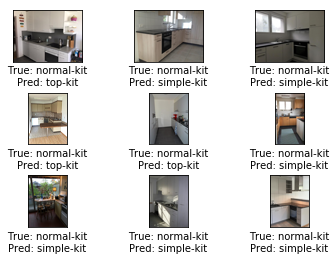

Confusion matrix:
[[ 31  42  39]
 [ 16  91   5]
 [  6   5 101]]
(0) normal-kit
(1) simple-kit
(2) top-kit


In [0]:
example_errors()

In [0]:
def predict(model, image_path, class_names):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    print('input_shape')
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array, batch_size=1)
    
    print (pred)

    for ind, score in enumerate(pred[0]):
      print("{0:>6.2%} {1}".format(score, class_names[ind]))
   

In [0]:
# def predict(image_path):
#     # Load and resize the image using PIL.
#     img = PIL.Image.open(image_path)
#     print('input_shape')
#     img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

#     # Plot the image.
#     plt.imshow(img_resized)
#     plt.show()

#     # Convert the PIL image to a numpy-array with the proper shape.
#     img_array = np.expand_dims(np.array(img_resized), axis=0)

#     # Use the VGG16 model to make a prediction.
#     # This outputs an array with 1000 numbers corresponding to
#     # the classes of the ImageNet-dataset.
#     pred = new_model.predict(img_array, batch_size=1)
#     print(pred)
#     # Decode the output of the VGG16 model.
#     #pred_decoded = decode_predictions(pred)[0]

#     # Print the predictions.
#     #for code, name, score in pred_decoded:
#         #print("{0:>6.2%} : {1}".format(score, name))
        

input_shape


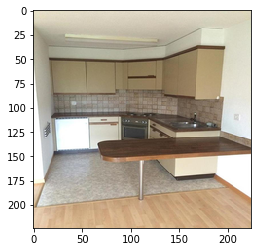

[[2.4608264e-23 4.4943263e-14 1.0000000e+00]]
 0.00% normal-kit
 0.00% simple-kit
100.00% top-kit


In [0]:
image_path='../gdrive/My Drive/classified/triple/kit/test/normal-kit/0a848f97404f3fdabafaad6ee19de7bb6df34fb7.jpg'

predict(model=new_model, image_path=image_path, class_names=class_names)

In [0]:
# saving_model = tf.keras.models.save_model(
#    new_model,
#    '/gdrive/My Drive/Colab Notebooks/Models/vgg_binary_kit_94.h5py',
#    overwrite=True,
#    include_optimizer=True,
#    save_format=None)